In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch


BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "Results"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

TICKERS = ["0050", "0056", "2330"]

GEN_PATHS = {
    "0050": RESULTS_DIR / "0050_generator1.pth",
    "0056": RESULTS_DIR / "0056_generator1.pth",
    "2330": RESULTS_DIR / "2330_generator1.pth",
}


def prepare_minutely_data(df: pd.DataFrame, trading_days: list):
    if df.empty:
        return None

    df = df.copy()
    df["bfValue"] = df["lastPx"] * df["size"]
    df["bfValue"] = df["bfValue"].ffill()
    df["cumValue"] = df.groupby("date")["bfValue"].cumsum()

    df = df[df["SP1"] > 0]
    df = df[df["BP1"] > 0]
    df = df[df["SP1"] - df["BP1"] > 0]

    for i in range(1, 6):
        df[f"SP{i}"] = df[f"SP{i}"] / 100
        df[f"BP{i}"] = df[f"BP{i}"] / 100
        df[f"SV{i}"] = df[f"SV{i}"] * 1000
        df[f"BV{i}"] = df[f"BV{i}"] * 1000

    df["lastPx"] = df["lastPx"] / 100
    df["size"] = df["size"] * 1000
    df["volume"] = df["volume"] * 1000

    df["lastPx"] = df.groupby("date")["lastPx"].ffill()
    df["size"] = df.groupby("date")["size"].transform(lambda x: x.fillna(0))

    df["value"] = df.groupby("date")["cumValue"].diff()
    df["value"] = df["value"].fillna(df["bfValue"])
    df = df.drop(columns=["bfValue", "cumValue", "value"])

    df_datetime = pd.to_datetime(
        df["date"].astype(str) + " " + df["time"].astype(str),
        format="%Y-%m-%d %H%M%S%f",
    )
    df["dt_index"] = df_datetime
    df = df[~df["dt_index"].duplicated(keep="last")]

    bin_size = "1min"
    df_minutely = df.groupby(
        pd.Grouper(key="dt_index", freq=bin_size, closed="right", label="right")
    ).last()

    for i in range(1, 6):
        for col in [f"SP{i}", f"BP{i}", f"SV{i}", f"BV{i}"]:
            df_minutely.loc[:, col] = df.groupby(
                pd.Grouper(key="dt_index", freq=bin_size, closed="right", label="right")
            )[col].last()

    df_minutely = df_minutely.between_time("09:00:00", "13:25:00", inclusive="right")
    df_minutely["date"] = df_minutely.index.date
    df_minutely["ttime"] = df_minutely.index.time
    df_minutely["time"] = df_minutely["time"].fillna(df_minutely["ttime"])
    df_minutely = df_minutely.drop(columns=["ttime"])

    df_minutely = df_minutely[df_minutely["date"].astype(str).isin(trading_days)]
    return df_minutely


TRAIN_COLS = [
    "date", "time", "lastPx", "size", "volume",
    "SP5", "SP4", "SP3", "SP2", "SP1",
    "BP1", "BP2", "BP3", "BP4", "BP5",
    "SV5", "SV4", "SV3", "SV2", "SV1",
    "BV1", "BV2", "BV3", "BV4", "BV5",
]


def load_test_minutely_sequences(stock: str):
    ym_list = ["202401", "202402", "202403"]
    df_all = pd.DataFrame()

    for ym in ym_list:
        path = DATA_DIR / f"{stock}_md_{ym}_{ym}.csv.gz"
        if path.exists():
            tmp = pd.read_csv(path, compression="gzip", usecols=TRAIN_COLS)
            df_all = pd.concat([df_all, tmp], ignore_index=True)
            print(f"[{stock}] Loaded test file:", path.name)
        else:
            print(f"[{stock}] Test file not found, skip:", path.name)

    if df_all.empty:
        raise RuntimeError(f"No test data found for {stock} in 202401-202403.")

    trading_days = sorted(df_all["date"].astype(str).unique())
    df_minutely = prepare_minutely_data(df_all, trading_days)
    print(f"[{stock}] Minutely test data shape:", df_minutely.shape)

    projdata = []
    day_list = []
    for d, day_df in df_minutely.groupby("date"):
        if day_df.shape[0] == 265:  
            projdata.append(day_df.values)
            day_list.append(str(d))

    if len(projdata) == 0:
        raise RuntimeError(f"No full 265-minute days found for {stock} in test period.")

    projdata = np.array(projdata)   
    print(f"[{stock}] Number of full test days:", projdata.shape[0])


    X_raw = projdata[:, :, 5:].astype(float)   

    X_raw[:, :, -10:] = np.log(1.0 + X_raw[:, :, -10:])

    X_mean = X_raw.mean(axis=1, keepdims=True)  # (N_day, 1, 20)
    X_std = X_raw.std(axis=1, keepdims=True)    # (N_day, 1, 20)

    X_norm = (X_raw - X_mean) / (2.0 * X_std)
    X_norm = np.nan_to_num(X_norm, nan=0.0, posinf=0.0, neginf=0.0)

    return X_norm, X_raw, X_mean, X_std, day_list


def load_trained_generator(stock: str) -> torch.nn.Module:
    path = GEN_PATHS.get(stock)
    if path is None:
        raise KeyError(f"Unknown stock key for generator: {stock}")
    if not path.exists():
        raise FileNotFoundError(f"Generator checkpoint not found: {path}")

    print(f"[{stock}] Loading generator from: {path.name}")
    gen = torch.load(path, map_location=DEVICE, weights_only=False)
    gen.eval()
    return gen


def generate_synthetic_sequences_for_stock(stock: str):
    X_norm, X_raw, X_mean, X_std, day_list = load_test_minutely_sequences(stock)

    gen = load_trained_generator(stock)
    x_tensor = torch.tensor(X_norm, dtype=torch.float32, device=DEVICE)
    with torch.no_grad():
        fake_norm = gen(x_tensor).cpu().numpy()   # (N_day, 265, 20)

    fake_raw = fake_norm * (2.0 * X_std) + X_mean

    fake_raw[:, :, -10:] = np.exp(fake_raw[:, :, -10:]) - 1.0

    return {
        "stock": stock,
        "day_list": day_list,
        "real_raw": X_raw,
        "fake_raw": fake_raw,
    }


results_q3 = {}
for s in TICKERS:
    print("=" * 60)
    print("Generating synthetic sequences for", s)
    results_q3[s] = generate_synthetic_sequences_for_stock(s)

print("Done. Keys in results_q3:", list(results_q3.keys()))


Using device: cpu
Generating synthetic sequences for 0050
[0050] Loaded test file: 0050_md_202401_202401.csv.gz
[0050] Loaded test file: 0050_md_202402_202402.csv.gz
[0050] Loaded test file: 0050_md_202403_202403.csv.gz
[0050] Minutely test data shape: (14840, 25)
[0050] Number of full test days: 56
[0050] Loading generator from: 0050_generator1.pth
Generating synthetic sequences for 0056
[0056] Loaded test file: 0056_md_202401_202401.csv.gz
[0056] Loaded test file: 0056_md_202402_202402.csv.gz
[0056] Loaded test file: 0056_md_202403_202403.csv.gz
[0056] Minutely test data shape: (14840, 25)
[0056] Number of full test days: 56
[0056] Loading generator from: 0056_generator1.pth
Generating synthetic sequences for 2330
[2330] Loaded test file: 2330_md_202401_202401.csv.gz
[2330] Loaded test file: 2330_md_202402_202402.csv.gz
[2330] Loaded test file: 2330_md_202403_202403.csv.gz
[2330] Minutely test data shape: (14840, 25)
[2330] Number of full test days: 56
[2330] Loading generator from: 

In [ ]:
# ====================== Cell A：统计表格（Real vs Synthetic）======================

import numpy as np
import pandas as pd
from IPython.display import display
assert "results_q3" in globals(), "results_q3 not found – please run the generation cell first."


def unpack_lob_features(x_2d: np.ndarray):
    x = np.asarray(x_2d)
    sp = x[:, 0:5]    # SP5..SP1
    bp = x[:, 5:10]   # BP1..BP5
    sv = x[:, 10:15]  # SV5..SV1
    bv = x[:, 15:20]  # BV1..BV5

    sp1 = sp[:, -1]
    bp1 = bp[:, 0]
    sv1 = sv[:, -1]
    bv1 = bv[:, 0]

    mid = (sp1 + bp1) / 2.0
    spread = sp1 - bp1
    top_depth = sv1 + bv1

    return sp1, bp1, sv1, bv1, mid, spread, top_depth


def compute_midquote_returns(mid: np.ndarray):
    mid = np.asarray(mid).astype(float)
    mid_prev = mid[:-1]
    mid_curr = mid[1:]
    denom = np.clip(mid_prev, 1e-6, None)
    return (mid_curr - mid_prev) / denom


def autocorr_lag1(x: np.ndarray):
    x = np.asarray(x).astype(float)
    x = x[np.isfinite(x)]
    if x.size <= 2:
        return np.nan
    return np.corrcoef(x[1:], x[:-1])[0, 1]


def coefficient_of_variation(x: np.ndarray):
    """CV = std / |mean|。"""
    x = np.asarray(x).astype(float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    mu = x.mean()
    sd = x.std()
    if mu == 0:
        return np.nan
    return sd / abs(mu)


def summarize_series_extended(x: np.ndarray):
    x = np.asarray(x).astype(float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return {
            "mean": np.nan,
            "std": np.nan,
            "skew": np.nan,
            "kurt": np.nan,
            "autocorr_lag1": np.nan,
            "CV": np.nan,
        }

    mu = x.mean()
    sd = x.std()
    if sd == 0:
        skew = 0.0
        kurt = 0.0
    else:
        z = (x - mu) / sd
        skew = np.mean(z ** 3)
        kurt = np.mean(z ** 4)

    ac1 = autocorr_lag1(x)
    cv = coefficient_of_variation(x)

    return {
        "mean": mu,
        "std": sd,
        "skew": skew,
        "kurt": kurt,
        "autocorr_lag1": ac1,
        "CV": cv,
    }


summary_tables = {}

for stock, res in results_q3.items():
    real_raw = res["real_raw"]   # (N_day, 265, 20)
    fake_raw = res["fake_raw"]

    real_all = real_raw.reshape(-1, real_raw.shape[-1])
    fake_all = fake_raw.reshape(-1, fake_raw.shape[-1])

    sp1_r, bp1_r, sv1_r, bv1_r, mid_r, spr_r, depth_r = unpack_lob_features(real_all)
    sp1_f, bp1_f, sv1_f, bv1_f, mid_f, spr_f, depth_f = unpack_lob_features(fake_all)

    # midquote return
    ret_r = compute_midquote_returns(mid_r)
    ret_f = compute_midquote_returns(mid_f)

    variables = {
        "Midquote": (mid_r, mid_f),
        "Spread": (spr_r, spr_f),
        "TopDepth": (depth_r, depth_f),
        "MidquoteReturn": (ret_r, ret_f),
    }

    rows = []
    for var_name, (x_real, x_fake) in variables.items():
        real_stats = summarize_series_extended(x_real)
        fake_stats = summarize_series_extended(x_fake)

        row = {"Variable": var_name}
        for k, v in real_stats.items():
            row[f"Real_{k}"] = v
        for k, v in fake_stats.items():
            row[f"Fake_{k}"] = v
        rows.append(row)

    df_summary = pd.DataFrame(rows).set_index("Variable")
    summary_tables[stock] = df_summary

    print("=" * 100)
    print(f"Enhanced Summary Statistics – {stock}")
    display(df_summary)


Enhanced Summary Statistics – 0050


,Real_mean,Real_std,Real_skew,Real_kurt,Real_autocorr_lag1,Real_CV,Fake_mean,Fake_std,Fake_skew,Fake_kurt,Fake_autocorr_lag1,Fake_CV
Variable,,,,,,,,,,,,
Midquote,142.617594,9.598721,0.305924,1.593464,0.999947,0.067304,142.582310,9.581718,0.304622,1.592437,0.999911,0.067201
Spread,0.067500,0.032759,2.196499,9.054088,0.409703,0.485314,0.086533,0.189803,0.582294,6.322102,0.613866,2.193425
TopDepth,20.753176,2.323279,-0.247980,2.822439,0.461590,0.111948,277340.142755,272865.064720,3.388637,19.819080,0.373447,0.983864
MidquoteReturn,0.000011,0.000701,22.437167,1370.174718,-0.013905,66.610146,0.000011,0.000901,13.373033,840.340395,0.047126,82.150372


Enhanced Summary Statistics – 0056


,Real_mean,Real_std,Real_skew,Real_kurt,Real_autocorr_lag1,Real_CV,Fake_mean,Fake_std,Fake_skew,Fake_kurt,Fake_autocorr_lag1,Fake_CV
Variable,,,,,,,,,,,,
Midquote,37.500431,1.342315,0.337522,1.875773,0.999932,0.035795,37.517614,1.346896e+00,0.342201,1.867637,0.999737,0.035900
Spread,0.012461,0.005958,3.364538,19.228416,0.364939,0.478108,0.021174,2.411480e-02,1.485819,10.886974,0.613727,1.138882
TopDepth,21.768835,2.599937,-0.174326,2.618290,0.486336,0.119434,779873.731955,1.487956e+06,3.329285,16.855003,0.547242,1.907944
MidquoteReturn,0.000004,0.000420,-5.006921,742.058017,0.067210,98.311298,0.000005,8.118351e-04,-2.869598,113.290592,0.278345,163.146249


Enhanced Summary Statistics – 2330


,Real_mean,Real_std,Real_skew,Real_kurt,Real_autocorr_lag1,Real_CV,Fake_mean,Fake_std,Fake_skew,Fake_kurt,Fake_autocorr_lag1,Fake_CV
Variable,,,,,,,,,,,,
Midquote,680.627392,73.930914,0.047483,1.541794,0.999932,0.108622,680.605922,73.891014,0.046068,1.538832,0.999942,0.108567
Spread,1.003032,0.056195,19.203715,394.509452,0.018427,0.056025,2.857379,1.033281,0.973296,3.462309,0.995493,0.361619
TopDepth,25.760572,1.576514,-0.284306,4.083904,0.882188,0.061199,600381.202395,349959.124334,2.594595,12.693583,0.996180,0.582895
MidquoteReturn,0.000019,0.001279,34.329559,2090.315801,-0.030688,66.235809,0.000019,0.001192,39.629783,2402.697725,-0.000948,62.890789


Figure 1: Time-series comparison (midquote & spread) on one test day


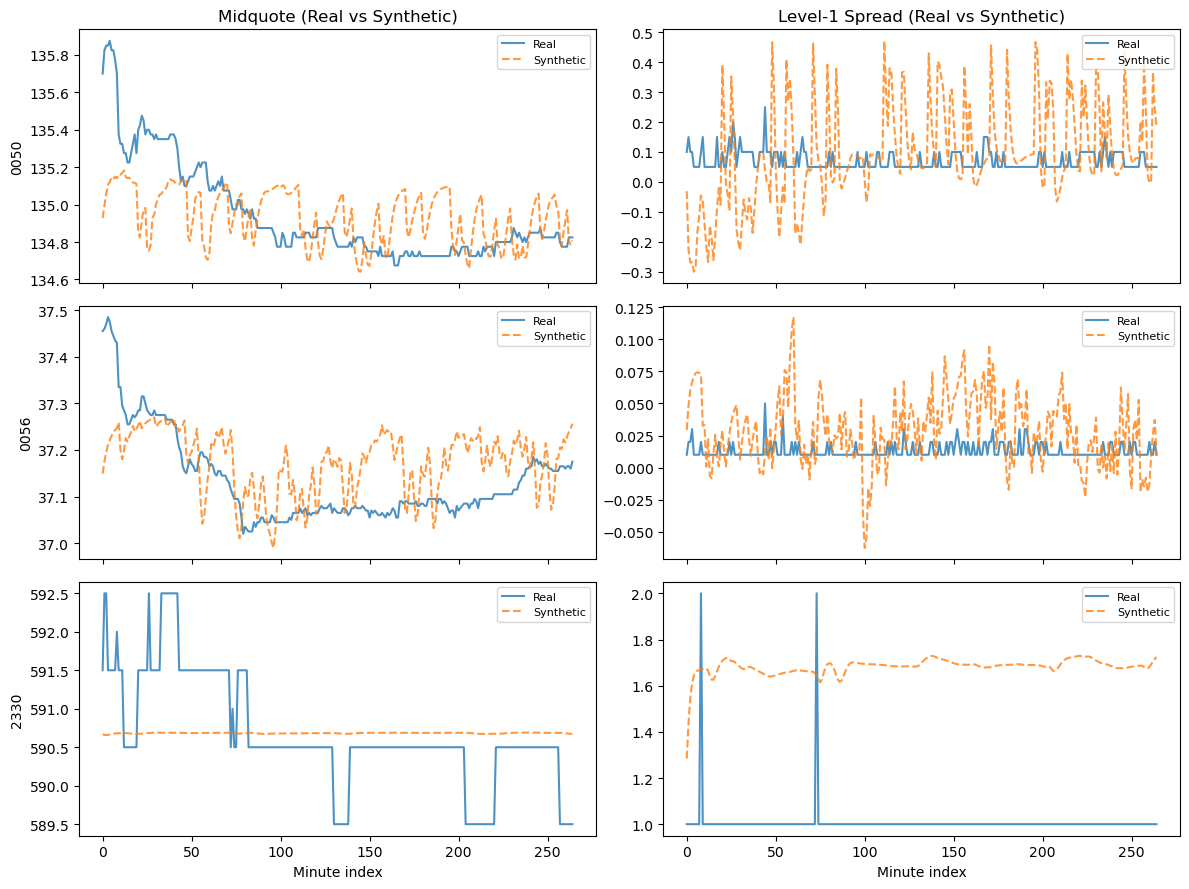

Figure 2: Distribution comparison (spread & midquote return) aggregated over all test days


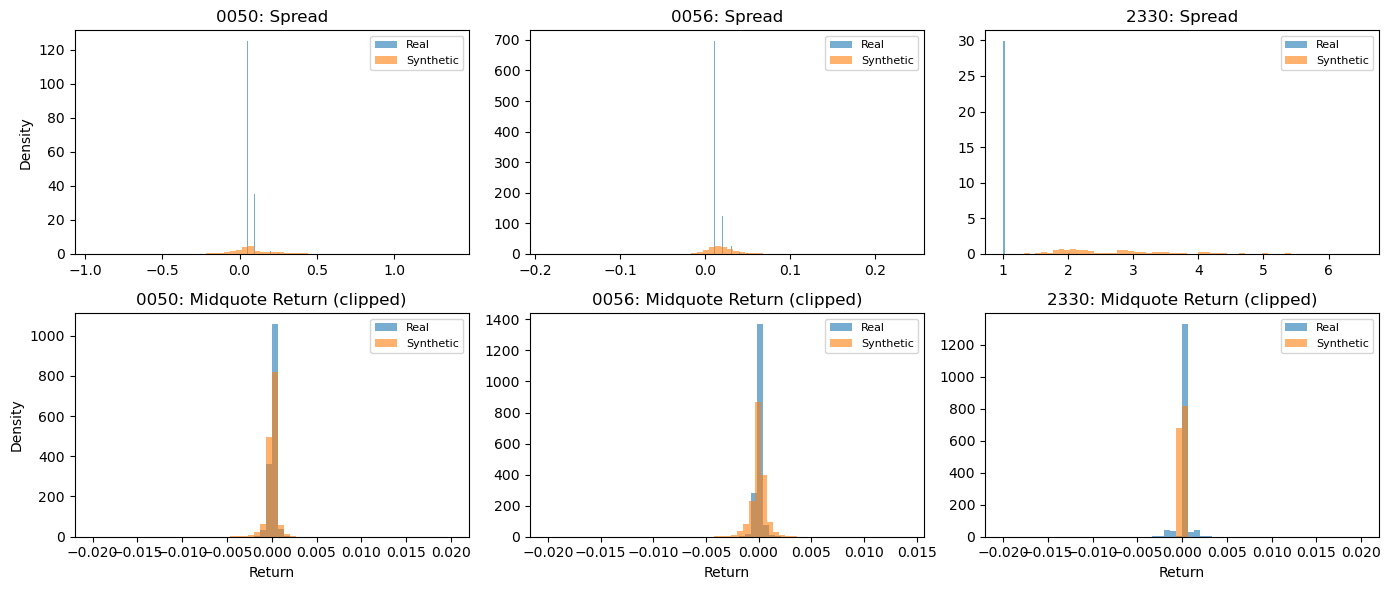

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)

def unpack_lob_features(x_2d: np.ndarray):
    x = np.asarray(x_2d)
    sp = x[:, 0:5]    # SP5..SP1
    bp = x[:, 5:10]   # BP1..BP5
    sv = x[:, 10:15]  # SV5..SV1
    bv = x[:, 15:20]  # BV1..BV5

    sp1 = sp[:, -1]
    bp1 = bp[:, 0]
    sv1 = sv[:, -1]
    bv1 = bv[:, 0]

    mid = (sp1 + bp1) / 2.0
    spread = sp1 - bp1
    top_depth = sv1 + bv1

    return sp1, bp1, sv1, bv1, mid, spread, top_depth


def compute_midquote_returns(mid: np.ndarray):
    mid = np.asarray(mid).astype(float)
    mid_prev = mid[:-1]
    mid_curr = mid[1:]
    denom = np.clip(mid_prev, 1e-6, None)
    return (mid_curr - mid_prev) / denom


def plot_panel_timeseries(results_q3: dict, day_index: int = 0, n_points: int = 265):
    stocks = ["0050", "0056", "2330"]
    fig, axes = plt.subplots(len(stocks), 2, figsize=(12, 9), sharex=True)

    for i, stock in enumerate(stocks):
        res = results_q3[stock]
        real_raw = res["real_raw"]
        fake_raw = res["fake_raw"]
        day_list = res["day_list"]

        assert 0 <= day_index < len(day_list), f"{stock}: day_index out of range"

        real_day = real_raw[day_index]  # (265, 20)
        fake_day = fake_raw[day_index]

        _, _, _, _, mid_r, spr_r, _ = unpack_lob_features(real_day)
        _, _, _, _, mid_f, spr_f, _ = unpack_lob_features(fake_day)

        n = min(n_points, len(mid_r))
        t = np.arange(n)

        ax_mid = axes[i, 0]
        ax_mid.plot(t, mid_r[:n], label="Real", alpha=0.8)
        ax_mid.plot(t, mid_f[:n], label="Synthetic", alpha=0.8, linestyle="--")
        if i == 0:
            ax_mid.set_title("Midquote (Real vs Synthetic)")
        ax_mid.set_ylabel(f"{stock}")
        ax_mid.legend(loc="upper right", fontsize=8)

        ax_sp = axes[i, 1]
        ax_sp.plot(t, spr_r[:n], label="Real", alpha=0.8)
        ax_sp.plot(t, spr_f[:n], label="Synthetic", alpha=0.8, linestyle="--")
        if i == 0:
            ax_sp.set_title("Level-1 Spread (Real vs Synthetic)")
        ax_sp.legend(loc="upper right", fontsize=8)

    axes[-1, 0].set_xlabel("Minute index")
    axes[-1, 1].set_xlabel("Minute index")

    plt.tight_layout()
    plt.show()


def plot_panel_distributions(results_q3: dict, bins_spread: int = 60, bins_ret: int = 60):
    stocks = ["0050", "0056", "2330"]
    fig, axes = plt.subplots(2, len(stocks), figsize=(14, 6))

    for j, stock in enumerate(stocks):
        res = results_q3[stock]
        real_raw = res["real_raw"]  # (N_day, 265, 20)
        fake_raw = res["fake_raw"]

        real_all = real_raw.reshape(-1, real_raw.shape[-1])
        fake_all = fake_raw.reshape(-1, fake_raw.shape[-1])

        _, _, _, _, mid_r, spr_r, _ = unpack_lob_features(real_all)
        _, _, _, _, mid_f, spr_f, _ = unpack_lob_features(fake_all)

        ret_r = compute_midquote_returns(mid_r)
        ret_f = compute_midquote_returns(mid_f)

        ax_sp = axes[0, j]
        ax_sp.hist(spr_r, bins=bins_spread, alpha=0.6, density=True, label="Real")
        ax_sp.hist(spr_f, bins=bins_spread, alpha=0.6, density=True, label="Synthetic")
        ax_sp.set_title(f"{stock}: Spread")
        if j == 0:
            ax_sp.set_ylabel("Density")
        ax_sp.legend(fontsize=8)

        clip_low, clip_high = -0.02, 0.02
        r_r = np.clip(ret_r, clip_low, clip_high)
        r_f = np.clip(ret_f, clip_low, clip_high)

        ax_rt = axes[1, j]
        ax_rt.hist(r_r, bins=bins_ret, alpha=0.6, density=True, label="Real")
        ax_rt.hist(r_f, bins=bins_ret, alpha=0.6, density=True, label="Synthetic")
        ax_rt.set_title(f"{stock}: Midquote Return (clipped)")
        ax_rt.set_xlabel("Return")
        if j == 0:
            ax_rt.set_ylabel("Density")
        ax_rt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


day_idx_for_ts = 0  

print("Figure 1: Time-series comparison (midquote & spread) on one test day")
plot_panel_timeseries(results_q3, day_index=day_idx_for_ts, n_points=265)

print("Figure 2: Distribution comparison (spread & midquote return) aggregated over all test days")
plot_panel_distributions(results_q3, bins_spread=60, bins_ret=60)
